In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


import random
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score


import warnings
import os
import sys


root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import *
from utils.constant import *

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
# Set a seed for reproducibility
np.random.seed(42)


In [7]:
file_path = get_absolute_path(
    'join_wo_forecast_error.csv',
    'data',
    PROJECT_BASE_DIR
)

data = pd.read_csv(file_path)

In [8]:
# Combine 'PRODUCT_CATEGORY_LEVEL1' and 'PRODUCT_CATEGORY_LEVEL3' into a new column
data['SEGMENT'] = data['CATEGORY_LEVEL1'] + ' - ' + data['CATEGORY_LEVEL3']


In [9]:
len(data)

30592

In [10]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30592 entries, 0 to 30591
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ORDER_PLACED_DTTM               30592 non-null  object 
 1   PRODUCT_PART_NUMBER             30592 non-null  int64  
 2   TOTAL_NET_SALES                 30592 non-null  float64
 3   TOTAL_UNITS                     30592 non-null  float64
 4   INVENTORY_SNAPSHOT_SNAPSHOT_DT  30592 non-null  object 
 5   TOTAL_CURRENT_ON_HAND           30592 non-null  int64  
 6   PRICE_SNAPSHOT_DATE             30592 non-null  object 
 7   CATEGORY_LEVEL1                 30591 non-null  object 
 8   CATEGORY_LEVEL2                 30591 non-null  object 
 9   CATEGORY_LEVEL3                 30591 non-null  object 
 10  MERCH_CLASSIFICATION1           30563 non-null  object 
 11  MERCH_CLASSIFICATION2           30563 non-null  object 
 12  MERCH_CLASSIFICATION3           

In [11]:
len(data)

30592

In [12]:
# Update the original DataFrame after dropping NaNs
data = data.dropna()


In [13]:
len(data)

26704

In [14]:
print(len(data.SEGMENT.unique()))
data.SEGMENT.unique()

85


array(['Dog - Biscuits & Crunchy Treats', 'Dog - Dental Treats',
       'Dog - Creams & Rinses', 'Fish - Water Conditioners',
       'Dog - Freeze-Dried & Dehydrated Food Toppings',
       'Bird - Feeders & Waterers', 'Wild Bird - Bird Feeders',
       'Horse - Brushes & Combs', 'Dog - Vitamins & Supplements',
       'Dog - Deodorizers', 'Dog - Outdoor Apparel',
       'Dog - Sprays, Foams & Wipes', 'Dog - Car Accessories',
       'Dog - Toys', 'Cat - Dry Food', 'Cat - Freeze Dried Treats',
       'Dog - Crates', 'Dog - Dry Food', 'Dog - Jerky Treats',
       'Dog - Bones', 'Cat - Medications', 'Pharmacy - Medications',
       'Pharmacy - Oral Treatments', 'Dog - Muzzles & Head Collars',
       'Cat - Brushes & Combs', 'Dog - Harnesses', 'Dog - Steps & Ramps',
       'Small Pet - Hay & Alfalfa', 'Fish - Algaecides & Water Clarity',
       'Dog - Beds', 'Dog - Shirts & Dresses', 'Dog - Leashes',
       'Cat - Collars', 'Fish - Food', 'Dog - Stress & Anxiety',
       'Cat - Wet Food Topp

In [15]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 26704 entries, 0 to 30591
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ORDER_PLACED_DTTM               26704 non-null  object 
 1   PRODUCT_PART_NUMBER             26704 non-null  int64  
 2   TOTAL_NET_SALES                 26704 non-null  float64
 3   TOTAL_UNITS                     26704 non-null  float64
 4   INVENTORY_SNAPSHOT_SNAPSHOT_DT  26704 non-null  object 
 5   TOTAL_CURRENT_ON_HAND           26704 non-null  int64  
 6   PRICE_SNAPSHOT_DATE             26704 non-null  object 
 7   CATEGORY_LEVEL1                 26704 non-null  object 
 8   CATEGORY_LEVEL2                 26704 non-null  object 
 9   CATEGORY_LEVEL3                 26704 non-null  object 
 10  MERCH_CLASSIFICATION1           26704 non-null  object 
 11  MERCH_CLASSIFICATION2           26704 non-null  object 
 12  MERCH_CLASSIFICATION3           26704

# EM Algorithm / Gaussian Mixture Model for Anomaly Detection

3 Major Things to Pay Attention to:

1. Our data contains missing values (NaN), and the GaussianMixture algorithm does not handle missing values natively. To address this issue, we need to handle missing values (I just dropped the `NET_SALES` or `UNITS` records that contains missing values) in our data before fitting the model. 
2. Need to tune hyperparameter `n_components`.
3. Need to decide the `threshold`.

### Given `n_components` and `threshold`

In this section, we assume `n_components = 5` (in this selected data, we have 8 segments), and `threshold = -50`. 


In [17]:
# Select the columns for anomaly detection
columns_for_anomaly_detection = ['TOTAL_NET_SALES', 'TOTAL_UNITS',
                                        'PRICE', 'LIST_PRICE', 
                                        'RATING_AVG', 'RATING_CNT',
                                        'TOTAL_CURRENT_ON_HAND'] # # metric_set 
data_for_anomaly_detection = data[columns_for_anomaly_detection]

# Check for missing values and handle them (replace NaN with a suitable strategy, e.g., mean)



In [18]:
# Standardize the data
scaler = StandardScaler()
data_for_anomaly_detection_standardized = scaler.fit_transform(data_for_anomaly_detection)



In [19]:
# Choose the number of components (clusters) for the GMM
n_components = 5  # You may need to adjust this based on the characteristics of your data

# Fit a Gaussian Mixture Model to the data
gmm = GaussianMixture(n_components=n_components, n_init=5, random_state=42)
gmm.fit(data_for_anomaly_detection_standardized)


GaussianMixture(n_components=5, n_init=5, random_state=42)

In [20]:
# Predict the labels (clusters) for each data point
labels = gmm.predict(data_for_anomaly_detection_standardized)

# Add the cluster labels to the original DataFrame
data['cluster_label'] = labels

In [22]:
columns_for_anomaly_detection

['TOTAL_NET_SALES',
 'TOTAL_UNITS',
 'PRICE',
 'LIST_PRICE',
 'RATING_AVG',
 'RATING_CNT',
 'TOTAL_CURRENT_ON_HAND']

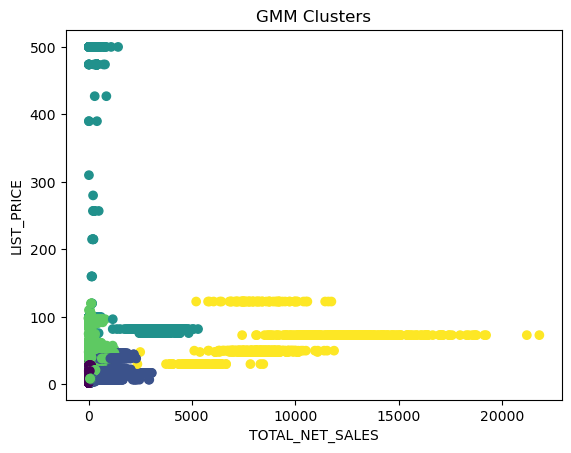

In [25]:
# Visualize the clusters
plt.scatter(data['TOTAL_NET_SALES'], data['LIST_PRICE'], c=labels, cmap='viridis')
plt.xlabel('TOTAL_NET_SALES')
plt.ylabel('LIST_PRICE')
plt.title('GMM Clusters')
plt.show()


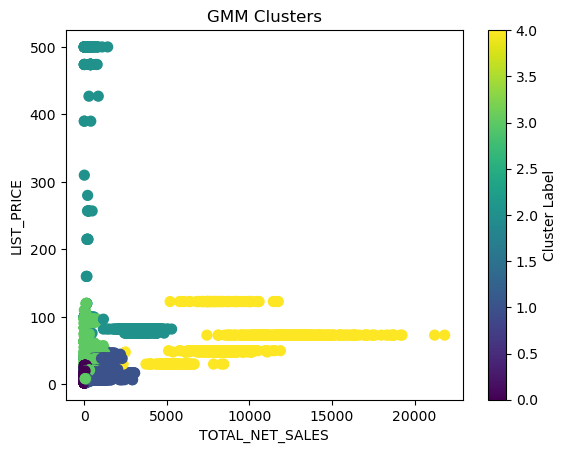

In [26]:
# Visualize the clusters with colorbar, different marker styles, and adjusted marker size
scatter = plt.scatter(data['TOTAL_NET_SALES'], data['LIST_PRICE'], c=labels, cmap='viridis', marker='o', s=50)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Customize the plot
plt.xlabel('TOTAL_NET_SALES')
plt.ylabel('LIST_PRICE')
plt.title('GMM Clusters')

# Show the plot
plt.show()


#### GMM Predict Anomalies Using Percentage Threshold

We will use the results from the Gaussian Mixture Model (GMM) to predict anomalies based on a percentage threshold. This percentage threshold is usually obtained through historical data or business knowledge. 

- Firstly, the score for each sample is obtained using the `score_samples` method.
- Secondly, the score is saved as a column in the pandas dataframe.
- After that, we get the score value for the percentage threshold set up for the anomaly detection, say, 5\%.
- Finally, a column is created based on the threshold. The data point is predicted to be an outlier if the score is les than the threshold.

In [27]:
# Get the score for each sample
score = gmm.score_samples(data_for_anomaly_detection_standardized)

# Save the score as a column
data['score'] = score

# Get the score threshold for anomaly
pct_threshold = np.percentile(score, 5)

# Print the score threshold
print(f'The threshold of the score is {pct_threshold:.2f}')

# Label the anomalies
data['anomaly_gmm_pct'] = data['score'].apply(lambda x: 1 if x < pct_threshold else 0)



The threshold of the score is -7.88


### GMM Predict Anomalies Using Value Threshold

We can use the results from Gaussian Mixture Model (GMM) to predict anomalies based on a value threshold. This value threshold is obtained by observing the distribution of scores. 

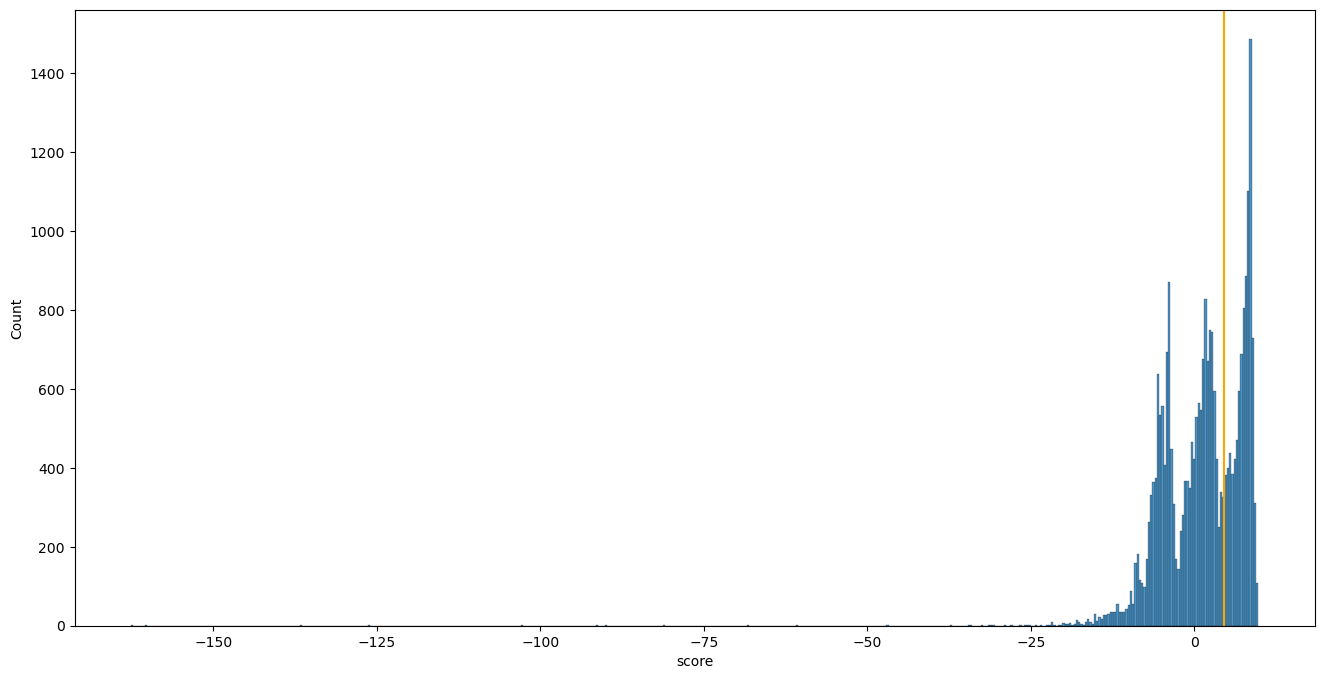

In [28]:
plt.figure(figsize = (16, 8))

sns.histplot(data['score'], bins = 500, alpha=0.8)

plt.axvline(x=4.5, color = 'orange')

In [29]:
# Get the score threshold for anomaly
value_threshold = -7.88
data['anomaly_gmm_value'] = data['score'].apply(lambda x: 1 if x < value_threshold else 0)


### GMM Anomaly Detection Optimization

- Hyperparameter Tuning
- Optimize the threshold

In [30]:
# Calculate the likelihood of each data point under the model
likelihoods = gmm.score_samples(data_for_anomaly_detection_standardized)

# Set a threshold for anomaly detection (you may need to adjust this)
threshold = -50  # Example threshold, adjust based on the distribution of likelihoods


In [31]:
# Identify anomalies based on the threshold
anomalies = data[likelihoods < threshold]

# Print or further analyze the anomalies
print(f"Anomalies:{len(anomalies)}")
print(anomalies)

Anomalies:10
      ORDER_PLACED_DTTM  PRODUCT_PART_NUMBER  TOTAL_NET_SALES  TOTAL_UNITS  \
7031         2023-11-24               151436          2923.70        704.0   
7032         2023-11-25               151436          2894.70        683.0   
7033         2023-11-26               151436          2194.97        529.0   
7034         2023-11-27               151436          2321.97        565.0   
7035         2023-11-28               151436          2446.26        589.0   
7036         2023-11-29               151436          2119.66        503.0   
16653        2023-04-26               282608           200.50          1.0   
16654        2023-09-11               282608             0.00          1.0   
22594        2023-11-08               653718           843.34          3.0   
22595        2023-11-27               653718           279.56          1.0   

      INVENTORY_SNAPSHOT_SNAPSHOT_DT  TOTAL_CURRENT_ON_HAND  \
7031                      2023-11-24                   9058   
70

In [33]:
columns_for_anomaly_detection

['TOTAL_NET_SALES',
 'TOTAL_UNITS',
 'PRICE',
 'LIST_PRICE',
 'RATING_AVG',
 'RATING_CNT',
 'TOTAL_CURRENT_ON_HAND']

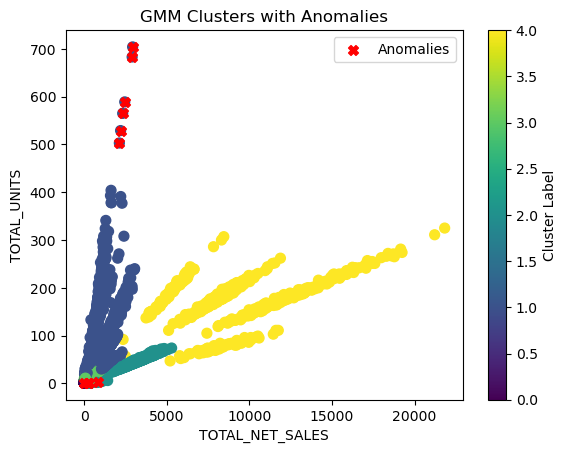

In [34]:
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

# Assuming you have already fit the Gaussian Mixture Model (GMM) and computed likelihoods
# (labels from GMM and likelihoods can be obtained using model.predict and model.score_samples)

# Visualize the clusters with colorbar, different marker styles, and adjusted marker size
scatter = plt.scatter(data['TOTAL_NET_SALES'], data['TOTAL_UNITS'], c=labels, cmap='viridis', marker='o', s=50)

# Identify anomalies based on the threshold
anomaly_mask = likelihoods < threshold
anomalies = data[anomaly_mask]

# Visualize anomalies with a different color and marker style
plt.scatter(anomalies['TOTAL_NET_SALES'], anomalies['TOTAL_UNITS'], c='red', marker='X', s=50, label='Anomalies')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Customize the plot
plt.xlabel('TOTAL_NET_SALES')
plt.ylabel('TOTAL_UNITS')
plt.title('GMM Clusters with Anomalies')
plt.legend()  # Show legend including the 'Anomalies' label

# Show the plot
plt.show()


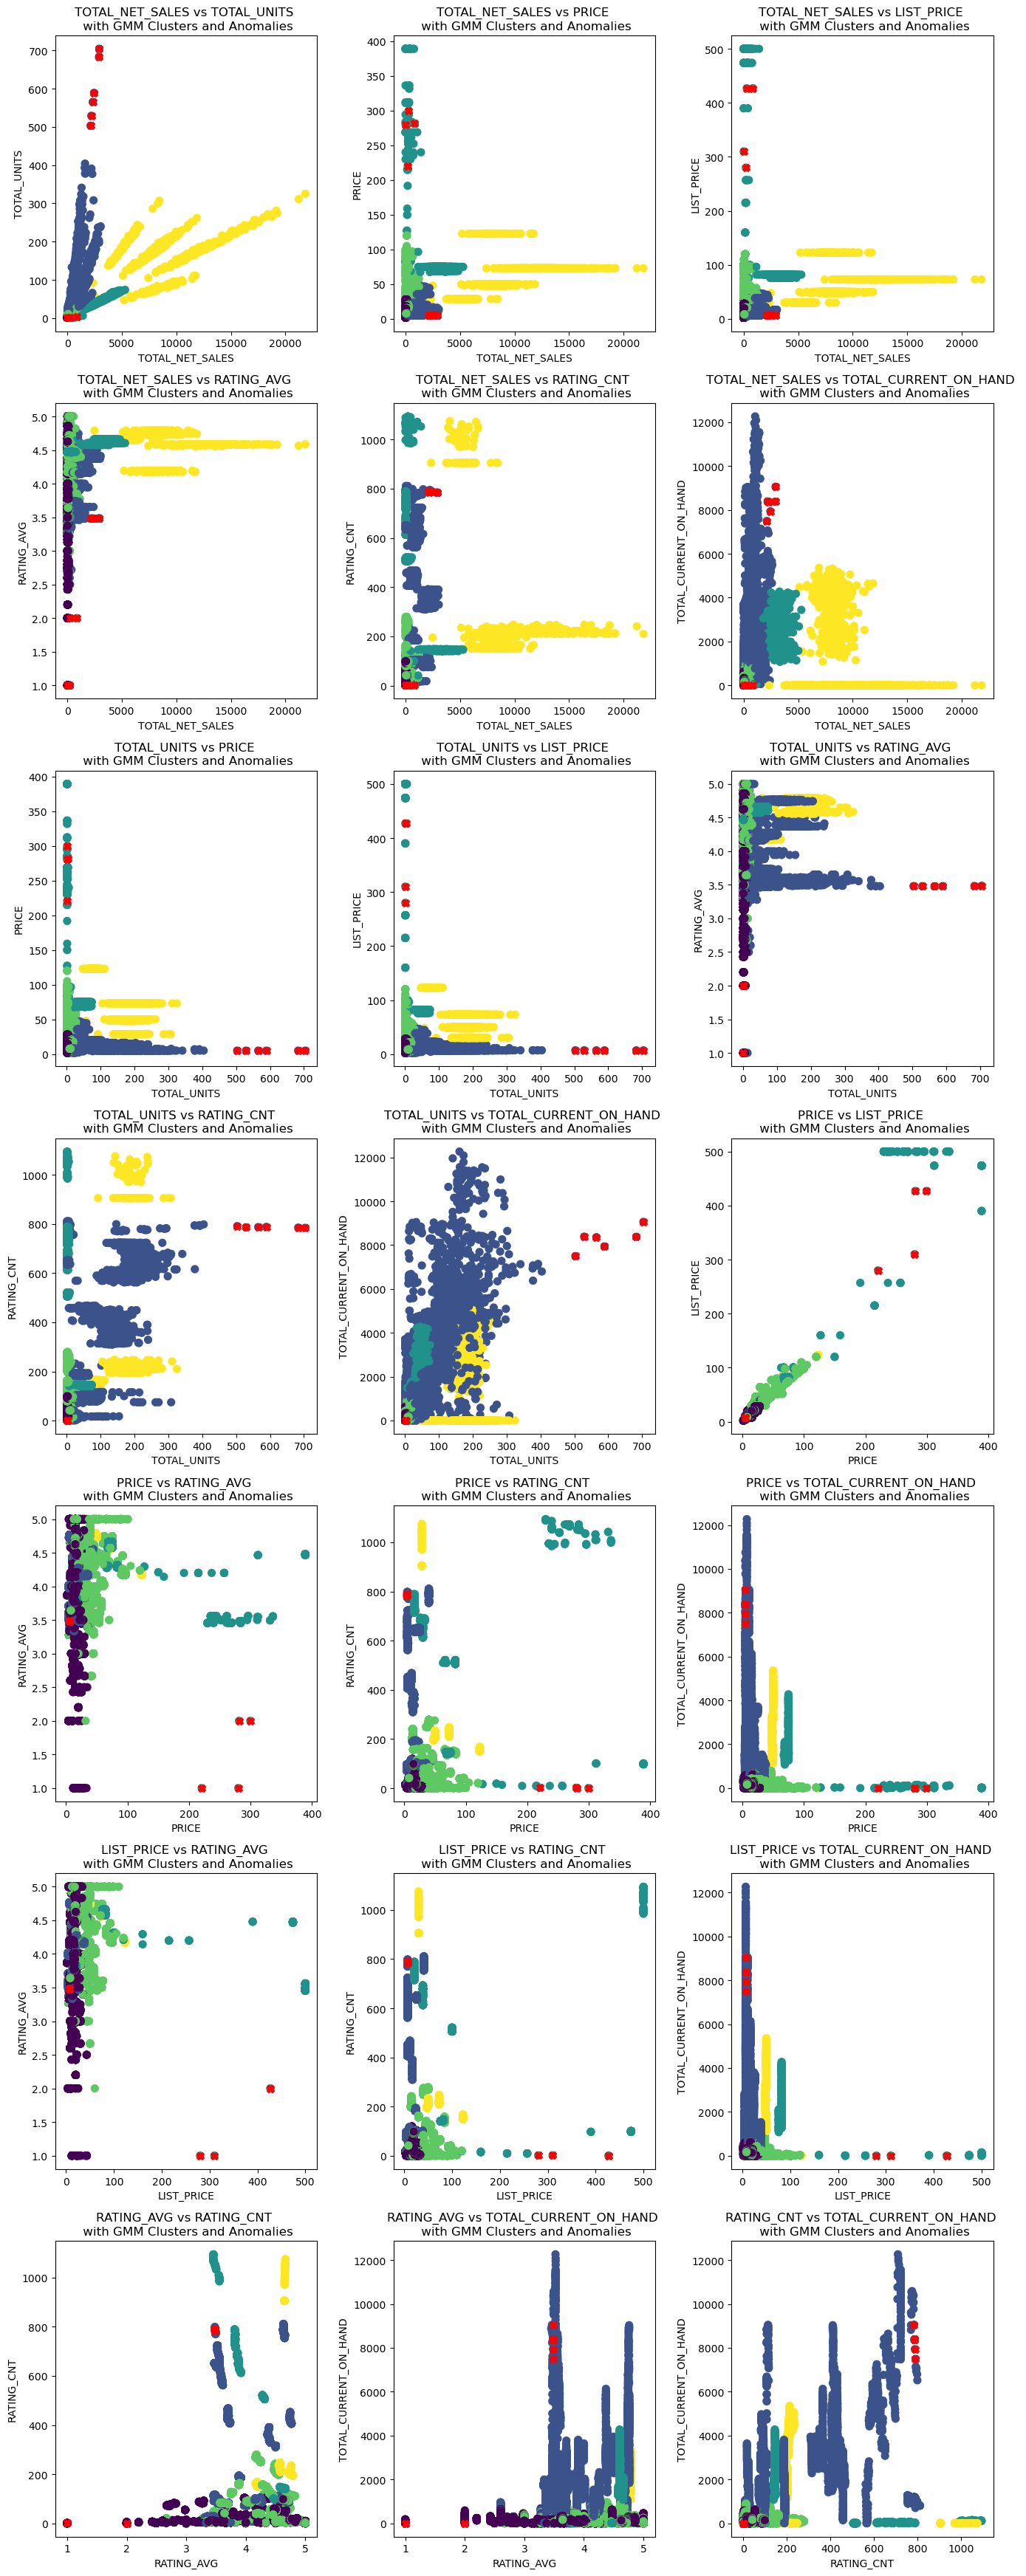

In [44]:
from itertools import combinations

# Assuming you have already fit the Gaussian Mixture Model (GMM) and computed likelihoods
# (labels from GMM and likelihoods can be obtained using model.predict and model.score_samples)

# Specify the columns for anomaly detection
columns_for_anomaly_detection = ['TOTAL_NET_SALES', 'TOTAL_UNITS', 'PRICE', 'LIST_PRICE', 'RATING_AVG', 'RATING_CNT', 'TOTAL_CURRENT_ON_HAND']

# Generate all combinations of columns
column_combinations = list(combinations(columns_for_anomaly_detection, 2))


# Create a grid of scatter plots
num_plots = len(column_combinations)
num_cols = 3
num_rows = -(-num_plots // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes for easy indexing
axes = axes.flatten()

# Iterate over column combinations
for i, (col1, col2) in enumerate(column_combinations):
    scatter = axes[i].scatter(data[col1], data[col2], c=labels, cmap='viridis', marker='o', s=50)
    anomaly_mask = likelihoods < threshold
    anomalies = data[anomaly_mask]
    axes[i].scatter(anomalies[col1], anomalies[col2], c='red', marker='X', s=50, label='Anomalies')
    axes[i].set_xlabel(col1)
    axes[i].set_ylabel(col2)
    axes[i].set_title(f'{col1} vs {col2} \n with GMM Clusters and Anomalies')

# # Add a colorbar
# cbar = fig.colorbar(scatter, ax=axes)
# cbar.set_label('Cluster Label')

# Move the legend to the right of the plots
fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to control the space for the legend
fig.subplots_adjust(right=0.9)  # Adjust the right parameter to control the space for the legend

# # Add a common legend outside the subplots
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')
plt.show()